In [1]:
import copy
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, models
import numpy as np
import matplotlib.pyplot as plt

In [2]:
train_dataset=datasets.FashionMNIST(root='../data',
                             train=True,
                             download=True,
                             transform=transforms.ToTensor())

test_dataset=datasets.FashionMNIST(root='../data',
                            train=False,
                            download=True,
                            transform=transforms.ToTensor())

In [3]:
batch_size = 32
n_iters = 10_000
num_epochs = int(n_iters * batch_size / len(train_dataset))
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [4]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.fc = nn.Linear(7*7*32, 10)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

In [5]:
input_size = 28 * 28
learning_rate = 0.001
model = CNN()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [6]:
device=('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
model.to(device)

cuda:0


CNN(
  (layer1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=1568, out_features=10, bias=True)
)

In [7]:
iter=0
for epoch in range(num_epochs):
    for i,(images,labels) in enumerate(train_loader):
        images, labels=images.to(device),labels.to(device)
        optimizer.zero_grad()
        outputs=model(images)
        loss=criterion(outputs,labels)
        loss.backward()
        optimizer.step()
        iter+=1
        if iter % 500 ==0:
            correct=0
            total=0
            for images,labels in test_loader:
                images,labels=images.to(device), labels.to(device)
                outputs=model(images)
                _,predictions=torch.max(outputs,1)
                total+=images.size()[0]
                correct+=(predictions==labels).sum()
                accuracy=float(100*correct)/total
         
            print('Loss ', loss.item(), 'Iteration ', iter, ' Accuracy ', accuracy)

Loss  0.39330488443374634 Iteration  500  Accuracy  83.84
Loss  0.22772394120693207 Iteration  1000  Accuracy  85.85
Loss  0.3574296236038208 Iteration  1500  Accuracy  87.02
Loss  0.08485358208417892 Iteration  2000  Accuracy  87.65
Loss  0.18854564428329468 Iteration  2500  Accuracy  87.71
Loss  0.2919601798057556 Iteration  3000  Accuracy  87.09
Loss  0.2707226276397705 Iteration  3500  Accuracy  88.36
Loss  0.21058616042137146 Iteration  4000  Accuracy  89.46
Loss  0.3997375965118408 Iteration  4500  Accuracy  88.18
Loss  0.1456291824579239 Iteration  5000  Accuracy  89.4
Loss  0.4065867066383362 Iteration  5500  Accuracy  89.42
Loss  0.1505652219057083 Iteration  6000  Accuracy  90.25
Loss  0.41883933544158936 Iteration  6500  Accuracy  90.48
Loss  0.26969361305236816 Iteration  7000  Accuracy  90.72
Loss  0.13931933045387268 Iteration  7500  Accuracy  90.28
Loss  0.06419845670461655 Iteration  8000  Accuracy  90.77
Loss  0.10149126499891281 Iteration  8500  Accuracy  90.42
Loss  

# (Iterative) Fast Gradient Sign Attack 
Proposed by Goodfellow et. al. in Explaining and Harnessing Adversarial Examples

In [16]:
def fgsm_attack(image, epsilon):
    sign_data_grad = image.grad.sign()
    perturbed_image = image + epsilon * sign_data_grad
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    return perturbed_image

In [17]:
m = 16
epsilon = 0.005
images_all = list()
adv_all = list()
correct = 0
total = 0

for images,labels in test_loader:
    images, labels = images.to(device), labels.to(device)
    adversarial_images = copy.deepcopy(images)
    
    for i in range(m):
        adversarial_images.requires_grad = True
        model.zero_grad()
        outputs = model(adversarial_images)
        loss = criterion(outputs, labels)
        loss.backward()
        adversarial_images = fgsm_attack(adversarial_images, epsilon).detach()
    
    _, predictions = torch.max(model(images), 1)
    _, adversarial_pred = torch.max(model(adversarial_images), 1)
    
    images_all.append([images.view(-1,28,28).detach().cpu().numpy(), labels])
    adv_all.append([adversarial_images.view(-1,28,28).detach().cpu().numpy(), adversarial_pred])

    correct += (labels==adversarial_pred).sum()
    total += len(predictions)
    
print("Error Rate is ",float(total-correct)*100/total)

Error Rate is  96.99


In [19]:
curr,label = images_all[0]
currad,labelad = adv_all[0]
print(type(curr), type(label))

<class 'numpy.ndarray'> <class 'torch.Tensor'>


In [20]:
label_mapping =  { 0: 'T-shirt/top',
                   1: 'Trouser',
                   2: 'Pullover',
                   3: 'Dress',
                   4: 'Coat',
                   5: 'Sandal',
                   6: 'Shirt',
                   7: 'Sneaker',
                   8: 'Bag',
                   9: 'Ankle boot'}

Original Label  Ankle boot  Adv Label  Sneaker


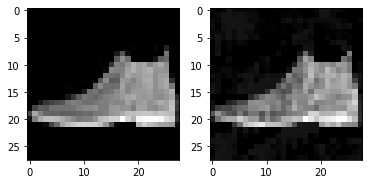

Original Label  Pullover  Adv Label  Coat


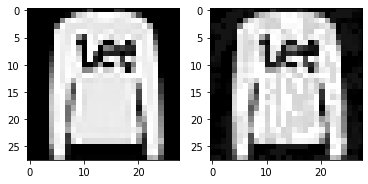

Original Label  Trouser  Adv Label  T-shirt/top


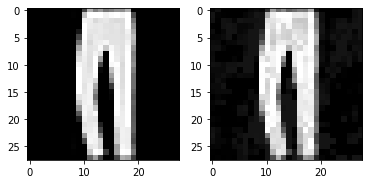

Original Label  Trouser  Adv Label  Trouser


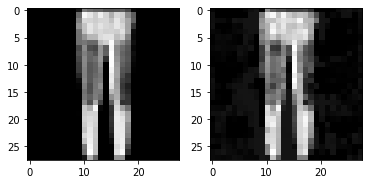

Original Label  Shirt  Adv Label  T-shirt/top


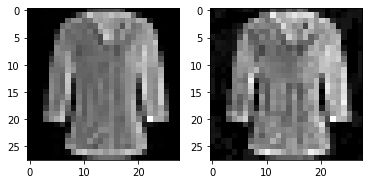

Original Label  Trouser  Adv Label  T-shirt/top


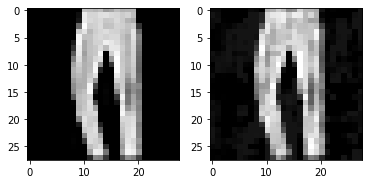

Original Label  Coat  Adv Label  Shirt


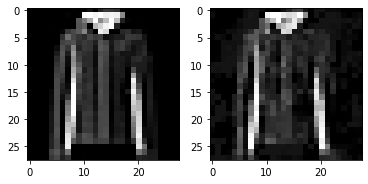

Original Label  Shirt  Adv Label  Coat


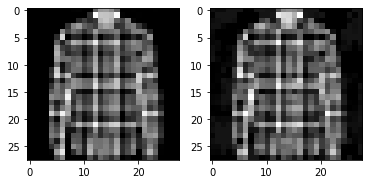

Original Label  Sandal  Adv Label  Sneaker


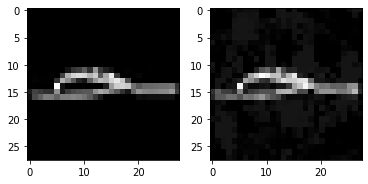

Original Label  Sneaker  Adv Label  Sandal


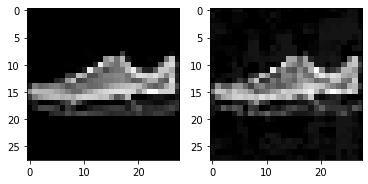

Batch Error rate  96.875


In [21]:
for a in range(0,10,1):
    plt.figure()
    plt.subplot(121)
    plt.imshow(curr[a],cmap='gray')
    plt.subplot(122)
    plt.imshow(currad[a],cmap='gray')
    print("Original Label ", label_mapping[int(label[a].cpu().numpy())], " Adv Label ",label_mapping[int(labelad[a].cpu().numpy())])
    plt.show()
    
total=batch_size
correct=(label==labelad).sum()
print("Batch Error rate ",float(total-correct)*100/total)

# Church Window Plots 
Proposed by Warde-Farley, David, and Ian Goodfellow. in "11 adversarial perturbations of deep neural networks." Perturbations, Optimization, and Statistics (2016)

In [22]:
#Finds the Ortonormal vector of a given input
def ort_torch(x):
    vert=torch.randn(x.shape).to(device)
    vert-=torch.mul(vert,x)*x
    vert/=torch.norm(vert)
    return vert

In [14]:
#Definining color for each class
colors = [[134, 24, 194], # 0 --> purple to pink intense
 [ 44 ,170, 223], # 1 --> medium to light blue
 [247 , 45 ,186], # 2 --> intense darker barbie pink
 [139, 195 , 58], # 3 --> medium lime green
 [ 49 , 59 , 55], # 4 --> dark grey
 [ 83, 102  ,98], # 5 --> light grey
 [219 , 17 , 59], # 6 --> intense pinkish red
 [116 , 56 ,240], # 7 --> cold intense purple to blue
 [155 , 32,  81], # 8 --> dark rose
 [ 21 , 40, 213]] # 9 --> intense royal blue

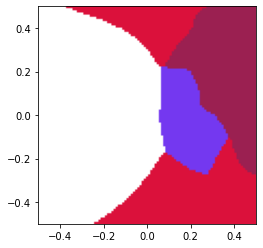

In [15]:
res=101
window=0.5
x=np.linspace(-window,window,res)
y=np.linspace(-window,window,res)
out=np.zeros([res,res,3],dtype=np.uint8)
data_loader=torch.utils.data.DataLoader(test_dataset, batch_size=1,
                                       shuffle=True)
for image,label in data_loader:
    image,label=image.to(device),label.to(device)
    image.requires_grad_()
    output=model(image)
    _,prediction=torch.max(output,1)
    
    loss=criterion(output,label)
    loss.backward()
    adv_direction=image.grad
    adv_normal=ort_torch(adv_direction)
    adv_direction=torch.sign(adv_direction)
    adv_normal=torch.sign(adv_normal)
    
    for a in range(y.size):
        for b in range(x.size):
            update=y[a]*adv_normal+x[b]*adv_direction
            update=update.to(device)
            image_adv=torch.clamp(image.detach()+update,0,1)
            _,adv_out=torch.max(model(image_adv),1)
            if(adv_out==label):
                out[a][b]=[255,255,255]
            else:
                out[a][b]=colors[adv_out]
    break

plt.imshow(out,extent=[-window,window,-window,window])